## Kaggle "News Category" Dataset

### (For Colab) Mount Drive, check environment, and install packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Check GPU
!nvidia-smi

Wed May  6 00:34:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-02v_70or
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-02v_70or
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31941 sha256=24ce2c658bc5cb5fe56135e6811fa9aeacb63c88142ddbdd72b64e4e2719c51e
  Stored in directory: /tmp/pip-ephem-wheel-cache-l732q4wa/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
     |████████████████████████████████| 711.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
# Verify MXNet detects GPU
import d2l
d2l.try_all_gpus()

# Should say [gpu(0)], NOT [cpu(0)]

[gpu(0)]

### Load data and encode labels

In [102]:
import pandas as pd
import numpy

# For local use
# newscat_raw = pd.read_json("./news-category-dataset/News_Category_Dataset_v2.json", lines = True)

# For Colab
newscat_raw = pd.read_json("/content/drive/My Drive/news-category-dataset/News_Category_Dataset_v2.json", lines = True)

newscat_raw.head()


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [166]:
len(newscat_raw)

200853

In [167]:
# We have over 200k examples.
pd.value_counts(newscat_raw['category'])


POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

There are 41 categories here, with as few as 1,004 examples (EDUCATION) and as many as 32,739 (POLITICS).

In [168]:
# Check for missing values
newscat_raw.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
full_description     0
dtype: int64

In [187]:
# This dataset is nice and clean! No null values to worry about!
# We have a headline, an author, and a short description to work with. Let's bring them all into one descriptor column

newscat_raw['full_description'] = newscat_raw[['authors','headline','short_description']].agg(' '.join, axis = 1)
newscat_raw.head()

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,Melissa Jeltsen There Were 2 Mass Shootings In...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Andy McDonald Will Smith Joins Diplo And Nicky...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Ron Dicker Hugh Grant Marries For The First Ti...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Ron Dicker Jim Carrey Blasts 'Castrato' Adam S...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Ron Dicker Julianna Margulies Uses Donald Trum...


In [110]:


# Let's remove the stopwords from our data
# We'll use the stopwords list from the nltk corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stop = stopwords.words('english')

In [0]:
newscat_raw['full_description'] = newscat_raw['full_description'].astype("string")

In [189]:
# Remove special characters
newscat_raw['full_description'] = newscat_raw['full_description'].str.replace('.,;:/*!-?^@#$%&+\)\(\'\"','',regex = True)
newscat_raw.head()

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,Melissa Jeltsen There Were 2 Mass Shootings In...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Andy McDonald Will Smith Joins Diplo And Nicky...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Ron Dicker Hugh Grant Marries For The First Ti...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Ron Dicker Jim Carrey Blasts 'Castrato' Adam S...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Ron Dicker Julianna Margulies Uses Donald Trum...


In [190]:
newscat_raw['full_description'] = newscat_raw['full_description'].str.lower().str.split()
newscat_raw['full_description'] = newscat_raw['full_description'].apply(lambda x: [item for item in x if item not in stop])
newscat_raw.head(10)

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,"[melissa, jeltsen, 2, mass, shootings, texas, ..."
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,"[andy, mcdonald, smith, joins, diplo, nicky, j..."
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,"[ron, dicker, hugh, grant, marries, first, tim..."
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,"[ron, dicker, jim, carrey, blasts, 'castrato',..."
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,"[ron, dicker, julianna, margulies, uses, donal..."
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26,"[ron, dicker, morgan, freeman, 'devastated', s..."
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26,"[ron, dicker, donald, trump, lovin', new, mcdo..."
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26,"[todd, van, luling, watch, amazon, prime, that..."
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26,"[andy, mcdonald, mike, myers, reveals, he'd, '..."
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26,"[todd, van, luling, watch, hulu, that’s, new, ..."


(array([3.7230e+03, 1.9321e+04, 3.5883e+04, 5.2064e+04, 3.8861e+04,
        1.9896e+04, 1.4956e+04, 1.0081e+04, 4.2610e+03, 1.2420e+03,
        2.5400e+02, 7.3000e+01, 3.0000e+01, 2.1000e+01, 1.2000e+01,
        1.4000e+01, 2.7000e+01, 2.9000e+01, 2.9000e+01, 3.1000e+01,
        1.6000e+01, 1.0000e+01, 7.0000e+00, 4.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.        ,   6.06666667,  11.13333333,  16.2       ,
         21.26666667,  26.33333333,  31.4       ,  36.46666667,
         41.53333333,  46.6       ,  51.66666667,  56.73333333,
         61.8       ,  66.86666667,  71.93333333,  77.        ,
         82.06666667,  87.13333333,  92.2       ,  97.26666667,
        102.33333333, 107.4       , 112.46666667, 117.53333333,
        122.6       , 127.66666667, 132.73333333, 137.8       ,
        142.86666667, 147.93333333, 153.        ]),
 <a list of 30 Patch objects>)

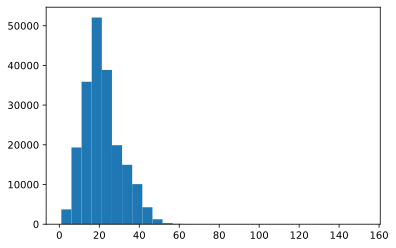

In [191]:
# Look at the token length of our descriptions

from matplotlib import pyplot as plt
plt.hist(newscat_raw['full_description'].apply(len), bins=30)

In [192]:
# 50 tokens should be enough to capture the vast majority of our descriptions in their entirety

# Now convert our text categories to panda categories for conversion to numeric labels
labels_raw = newscat_raw["category"].astype('category')
labels_raw["category"] = newscat_raw["category"].astype('category')
labels_raw.head()

0            CRIME
1    ENTERTAINMENT
2    ENTERTAINMENT
3    ENTERTAINMENT
4    ENTERTAINMENT
Name: category, dtype: object

In [193]:
len(labels_raw["category"])

200853

In [194]:
labels_raw['catnum'] = labels_raw["category"].cat.codes
labels_raw['catnum']

0          6
1         10
2         10
3         10
4         10
          ..
200848    32
200849    28
200850    28
200851    28
200852    28
Length: 200853, dtype: int8

Create dictionary for going back and forth between codes and category names

In [195]:
category_dict = dict(enumerate(labels_raw["category"].cat.categories))
category_dict

{0: 'ARTS',
 1: 'ARTS & CULTURE',
 2: 'BLACK VOICES',
 3: 'BUSINESS',
 4: 'COLLEGE',
 5: 'COMEDY',
 6: 'CRIME',
 7: 'CULTURE & ARTS',
 8: 'DIVORCE',
 9: 'EDUCATION',
 10: 'ENTERTAINMENT',
 11: 'ENVIRONMENT',
 12: 'FIFTY',
 13: 'FOOD & DRINK',
 14: 'GOOD NEWS',
 15: 'GREEN',
 16: 'HEALTHY LIVING',
 17: 'HOME & LIVING',
 18: 'IMPACT',
 19: 'LATINO VOICES',
 20: 'MEDIA',
 21: 'MONEY',
 22: 'PARENTING',
 23: 'PARENTS',
 24: 'POLITICS',
 25: 'QUEER VOICES',
 26: 'RELIGION',
 27: 'SCIENCE',
 28: 'SPORTS',
 29: 'STYLE',
 30: 'STYLE & BEAUTY',
 31: 'TASTE',
 32: 'TECH',
 33: 'THE WORLDPOST',
 34: 'TRAVEL',
 35: 'WEDDINGS',
 36: 'WEIRD NEWS',
 37: 'WELLNESS',
 38: 'WOMEN',
 39: 'WORLD NEWS',
 40: 'WORLDPOST'}

### Partition into train, validate, and test

In [0]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn, rnn
from mxnet.contrib import text
import numpy
import random
npx.set_np()

In [0]:
# Partition into training, validation, and test
train_pct = .8
validation_pct = .1
# Test set will be remainder of examples

num_examples = len(labels_raw['catnum'])
rownums = list(range(num_examples))

random.shuffle(rownums)

train_examples = int(num_examples * train_pct)
validation_examples = int(num_examples * validation_pct)

trainsetnums = rownums[:train_examples]
validsetnums = rownums[train_examples: train_examples + validation_examples]
testsetnums = rownums[train_examples + validation_examples: ]

In [197]:
print("Train/Validate/Test count: ", len(trainsetnums), len(validsetnums), len(testsetnums))

Train/Validate/Test count:  160682 20085 20086


In [0]:
Examples_train = list(newscat_raw['full_description'][trainsetnums])
Examples_validation = list(newscat_raw['full_description'][validsetnums])
Examples_test = list(newscat_raw['full_description'][testsetnums])

train_labels = list(labels_raw['catnum'][trainsetnums])
validation_labels = list(labels_raw['catnum'][validsetnums])
test_labels = list(labels_raw['catnum'][testsetnums])

In [0]:
y_train = np.array(labels_raw['catnum'][trainsetnums], dtype = np.float32).reshape(-1, 1)
y_validation = np.array(labels_raw['catnum'][validsetnums], dtype = np.float32).reshape(-1, 1)
y_test = np.array(labels_raw['catnum'][testsetnums], dtype = np.float32).reshape(-1, 1)


In [200]:
print(y_train.shape, len(Examples_train))
print(y_validation.shape, len(Examples_validation))
print(y_test.shape, len(Examples_test))

(160682, 1) 160682
(20085, 1) 20085
(20086, 1) 20086


### Tokenize examples

Tokenization and vocabulary functions from d2l chapter 8, Text Preproicessing

In [0]:
def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split(' ') for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type '+token)
        
# train_tokens = tokenize(Examples_train, token = 'word')
# validation_tokens = tokenize(Examples_validation, token = 'word')
# test_tokens = tokenize(Examples_test, token = 'word')

# Already split into words above
train_tokens = Examples_train
validation_tokens = Examples_validation
test_tokens = Examples_test

Let's look at some random examples from the training data to see if our headlines and categories make sense.

In [203]:
example_num = random.randint(0,len(trainsetnums))
print(train_tokens[example_num])
print(category_dict.get(int(y_train[example_num])))

['daniel', 'marans', 'chris', 'christie', 'mike', 'huckabee', 'exchange', 'blows', 'social', 'security', 'debate', 'marks', 'rift', 'within', 'republican', 'field', 'popular', 'social', 'insurance', 'program.']
POLITICS


### Word Embeddings

In [0]:
# TODO(JC): I'm trying to avoid calling the d2l package directly, but I'm having a hard time  
#           adapting the Vocab function from the version defined in d2l 8.2

import d2l
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>']) 

In [205]:
print(vocab.token_freqs[:20]) # Check the most frequent words. The stop words should be eliminated! 

# TODO (JC): The special characters are still showing up. The code to remove them doesn't seem to be working.
# Anyone in the group good with regular expressions?

[('contributor', 30442), ('new', 15663), ('one', 11637), ('--', 11538), ('trump', 9658), ('like', 8672), ('people', 8378), ('time', 7478), ('get', 7407), ('make', 7136), ('(photos)', 6719), ('first', 6088), ('us', 5860), ('&', 5742), ('best', 5688), ('may', 5651), ('day', 5647), ('would', 5495), ('know', 5434), ('could', 5430)]


In [206]:
# Load pre-trained GloVe word embedding. This is available as a resource in mxnet. 
# We'll follow d2l's lead and use the 100d version
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')

# Check the dimentions of our embeddings (should be vocab size x dimensionality of embedding we chose)
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(53026, 100)

### Data iterator

In [207]:
num_steps = 50  # sequence length. We saw above that 50 should be plenty.
train_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

validation_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in validation_tokens])
print(validation_features.shape)

test_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
print(test_features.shape)


(160682, 50)
(20085, 50)
(20086, 50)


In [0]:
X_train = np.array(train_features, dtype = np.float32)
X_validation = np.array(validation_features, dtype = np.float32)
X_test = np.array(test_features, dtype = np.float32)

In [209]:
batch_size = 128
train_iter = d2l.load_array((train_features, train_labels), batch_size)   ###JC: Another invocation of d2l library
validation_iter = d2l.load_array((validation_features, validation_labels), batch_size, is_train = False)   
test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)   


for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (128, 50) y (128,)


('# batches:', 1256)

### Bi-LSTM (D2L Setup)

In [0]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.decoder = nn.Dense(41)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

In [213]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(53026, 100)

In [0]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

loss 0.761, train acc 0.773, test acc 0.740
5310.7 examples/sec on [gpu(0)]
Training time 365.01761 sec


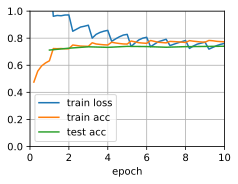

In [215]:
timer = d2l.Timer()
lr, num_epochs = 0.01, 10
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, validation_iter, loss, trainer, num_epochs, ctx)
print('Training time %.5f sec' % timer.stop())

In [277]:
# Look at random validation examples, their actual categories, and their predicted categories

example_num = random.randint(0,len(validation_labels))
pred_example = np.array(validation_features[example_num].reshape(1, -1), ctx=d2l.try_gpu())
pred_cat = category_dict.get(int(np.argmax(net(pred_example))))

print(validation_tokens[example_num])
print("Actual: ", category_dict.get(int(y_validation[example_num])))
print("Predicted: ", pred_cat)

['zach', 'carter', 'donald', 'trump', 'got', 'votes', 'ohio', 'hillary', 'clinton', 'democrats', 'still', 'turnout', 'problem.']
Actual:  POLITICS
Predicted:  POLITICS
